In [1]:
%cd ..

C:\cygwin64\home\evger\thesis


In [2]:
from hft.environment import sampler
import pandas as pd
import glob
import os

In [3]:
dst_dir = 'notebooks/time-sampled-30min'

In [5]:
if not os.path.exists(dst_dir):
    seconds = 1800
    samplerr = sampler.TimeSampler('tests/resources/may1/orderbooks/0.csv.gz',
                                   'tests/resources/may1/trades/0.csv.gz',
                                   dst_dir, seconds, nrows=700000, max_workers=8)
    samplerr.split_samples()

2020-05-28 00:31:22,138 - <sampler> - INFO - Loaded TimeSampler
2020-05-28 00:31:25,889 - <sampler> - INFO - Task for file trade_0 finished
2020-05-28 00:31:26,024 - <sampler> - INFO - Task for file trade_2 finished
2020-05-28 00:31:26,448 - <sampler> - INFO - Task for file trade_1 finished
2020-05-28 00:31:28,529 - <sampler> - INFO - Task for file trade_3 finished
2020-05-28 00:31:30,143 - <sampler> - INFO - Task for file trade_4 finished
2020-05-28 00:31:34,787 - <sampler> - INFO - Task for file orderbook_4 finished
2020-05-28 00:32:10,458 - <sampler> - INFO - Task for file orderbook_2 finished
2020-05-28 00:32:17,140 - <sampler> - INFO - Task for file orderbook_1 finished
2020-05-28 00:32:20,436 - <sampler> - INFO - Task for file orderbook_0 finished
2020-05-28 00:32:22,259 - <sampler> - INFO - Task for file orderbook_3 finished
2020-05-28 00:32:29,481 - <sampler> - INFO - Reload orderbook df
2020-05-28 00:32:32,358 - <sampler> - INFO - Task for file trade_6 finished
2020-05-28 00:3

2020-05-28 00:42:00,774 - <sampler> - INFO - Task for file orderbook_47 finished
2020-05-28 00:42:00,774 - <sampler> - INFO - Reload trade df
2020-05-28 00:42:03,430 - <sampler> - INFO - Task for file trade_48 finished
2020-05-28 00:42:29,265 - <sampler> - INFO - Task for file orderbook_48 finished
2020-05-28 00:42:56,275 - <sampler> - INFO - Reload orderbook df
2020-05-28 00:42:59,724 - <sampler> - INFO - Task for file trade_49 finished
2020-05-28 00:43:04,996 - <sampler> - INFO - Task for file trade_51 finished
2020-05-28 00:43:06,640 - <sampler> - INFO - Task for file trade_50 finished
2020-05-28 00:44:03,006 - <sampler> - INFO - Task for file orderbook_51 finished
2020-05-28 00:44:04,799 - <sampler> - INFO - Task for file orderbook_49 finished
2020-05-28 00:44:15,979 - <sampler> - INFO - Task for file orderbook_50 finished
2020-05-28 00:44:46,305 - <sampler> - INFO - Reload orderbook df
2020-05-28 00:44:54,437 - <sampler> - INFO - Task for file trade_52 finished
2020-05-28 00:44:54

2020-05-28 01:06:56,752 - <sampler> - INFO - Task for file orderbook_90 finished
2020-05-28 01:08:01,270 - <sampler> - INFO - Reload orderbook df
2020-05-28 01:08:09,311 - <sampler> - INFO - Reload trade df
2020-05-28 01:08:34,452 - <sampler> - INFO - Task for file trade_95 finished
2020-05-28 01:08:39,501 - <sampler> - INFO - Task for file trade_94 finished
2020-05-28 01:08:43,211 - <sampler> - INFO - Task for file trade_93 finished
2020-05-28 01:09:00,749 - <sampler> - INFO - Task for file orderbook_95 finished
2020-05-28 01:09:45,697 - <sampler> - INFO - Task for file orderbook_94 finished
2020-05-28 01:09:48,501 - <sampler> - INFO - Task for file orderbook_93 finished
2020-05-28 01:10:54,179 - <sampler> - INFO - Reload orderbook df
2020-05-28 01:11:01,805 - <sampler> - INFO - Reload trade df
2020-05-28 01:11:11,435 - <sampler> - INFO - Task for file orderbook_99 finished
2020-05-28 01:11:21,548 - <sampler> - INFO - Task for file trade_96 finished
2020-05-28 01:11:24,034 - <sampler>

2020-05-28 01:36:44,897 - <sampler> - INFO - Task for file trade_139 finished
2020-05-28 01:37:10,828 - <sampler> - INFO - Task for file orderbook_139 finished
2020-05-28 01:37:18,442 - <sampler> - INFO - Task for file orderbook_136 finished
2020-05-28 01:37:19,174 - <sampler> - INFO - Task for file orderbook_137 finished
2020-05-28 01:37:20,340 - <sampler> - INFO - Task for file orderbook_138 finished
2020-05-28 01:37:21,533 - <sampler> - INFO - Task for file orderbook_135 finished
2020-05-28 01:38:53,485 - <sampler> - INFO - Reload orderbook df
2020-05-28 01:38:59,041 - <sampler> - INFO - Task for file trade_142 finished
2020-05-28 01:39:03,130 - <sampler> - INFO - Task for file trade_140 finished
2020-05-28 01:39:06,334 - <sampler> - INFO - Task for file trade_141 finished
2020-05-28 01:39:34,403 - <sampler> - INFO - Task for file orderbook_140 finished
2020-05-28 01:39:35,132 - <sampler> - INFO - Task for file orderbook_142 finished
2020-05-28 01:39:37,206 - <sampler> - INFO - Task

2020-05-28 01:59:19,631 - <sampler> - INFO - Task for file trade_184 finished
2020-05-28 01:59:21,180 - <sampler> - INFO - Task for file trade_183 finished
2020-05-28 01:59:45,469 - <sampler> - INFO - Task for file orderbook_184 finished
2020-05-28 01:59:46,876 - <sampler> - INFO - Task for file orderbook_183 finished
2020-05-28 01:59:52,764 - <sampler> - INFO - Reload trade df
2020-05-28 01:59:59,060 - <sampler> - INFO - Task for file trade_187 finished
2020-05-28 01:59:59,386 - <sampler> - INFO - Task for file trade_186 finished
2020-05-28 01:59:59,879 - <sampler> - INFO - Task for file trade_188 finished
2020-05-28 02:00:00,167 - <sampler> - INFO - Task for file trade_185 finished
2020-05-28 02:00:02,503 - <sampler> - INFO - Task for file trade_189 finished
2020-05-28 02:00:10,464 - <sampler> - INFO - Task for file orderbook_189 finished
2020-05-28 02:00:37,284 - <sampler> - INFO - Task for file orderbook_187 finished
2020-05-28 02:00:38,588 - <sampler> - INFO - Task for file orderb

2020-05-28 02:20:18,680 - <sampler> - INFO - Reload orderbook df
2020-05-28 02:20:36,263 - <sampler> - INFO - Reload trade df
2020-05-28 02:20:37,243 - <sampler> - INFO - Task for file trade_231 finished
2020-05-28 02:20:40,979 - <sampler> - INFO - Task for file trade_233 finished
2020-05-28 02:20:41,323 - <sampler> - INFO - Task for file trade_232 finished
2020-05-28 02:20:41,464 - <sampler> - INFO - Task for file trade_234 finished
2020-05-28 02:20:43,778 - <sampler> - INFO - Task for file trade_235 finished
2020-05-28 02:20:45,398 - <sampler> - INFO - Task for file trade_236 finished
2020-05-28 02:20:48,380 - <sampler> - INFO - Task for file trade_237 finished
2020-05-28 02:21:49,325 - <sampler> - INFO - Task for file orderbook_237 finished
2020-05-28 02:21:54,331 - <sampler> - INFO - Task for file trade_238 finished
2020-05-28 02:21:54,369 - <sampler> - INFO - Task for file orderbook_235 finished
2020-05-28 02:21:54,541 - <sampler> - INFO - Task for file orderbook_238 finished
2020

2020-05-28 02:41:43,126 - <sampler> - INFO - Task for file orderbook_277 finished
2020-05-28 02:43:24,439 - <sampler> - INFO - Reload orderbook df
2020-05-28 02:43:28,332 - <sampler> - INFO - Task for file trade_280 finished
2020-05-28 02:43:34,116 - <sampler> - INFO - Task for file trade_279 finished
2020-05-28 02:43:59,560 - <sampler> - INFO - Task for file orderbook_280 finished
2020-05-28 02:44:05,610 - <sampler> - INFO - Task for file orderbook_279 finished
2020-05-28 02:44:11,568 - <sampler> - INFO - Reload trade df
2020-05-28 02:44:16,967 - <sampler> - INFO - Task for file trade_281 finished
2020-05-28 02:44:21,374 - <sampler> - INFO - Task for file trade_282 finished
2020-05-28 02:44:43,790 - <sampler> - INFO - Task for file orderbook_282 finished
2020-05-28 02:44:47,472 - <sampler> - INFO - Task for file orderbook_281 finished
2020-05-28 02:46:49,762 - <sampler> - INFO - Reload orderbook df
2020-05-28 02:46:54,685 - <sampler> - INFO - Task for file trade_285 finished
2020-05-2

2020-05-28 03:22:30,064 - <sampler> - INFO - Task for file orderbook_320 finished
2020-05-28 03:24:19,788 - <sampler> - INFO - Reload orderbook df
2020-05-28 03:24:23,659 - <sampler> - INFO - Task for file trade_324 finished
2020-05-28 03:24:24,429 - <sampler> - INFO - Task for file trade_326 finished
2020-05-28 03:24:29,958 - <sampler> - INFO - Task for file trade_325 finished
2020-05-28 03:25:03,065 - <sampler> - INFO - Task for file orderbook_324 finished
2020-05-28 03:25:17,463 - <sampler> - INFO - Task for file orderbook_326 finished
2020-05-28 03:25:20,226 - <sampler> - INFO - Task for file orderbook_325 finished
2020-05-28 03:27:07,540 - <sampler> - INFO - Reload orderbook df
2020-05-28 03:27:18,637 - <sampler> - INFO - Reload trade df
2020-05-28 03:27:24,540 - <sampler> - INFO - Task for file trade_329 finished
2020-05-28 03:27:25,595 - <sampler> - INFO - Task for file trade_327 finished
2020-05-28 03:27:27,890 - <sampler> - INFO - Task for file trade_328 finished
2020-05-28 03

2020-05-28 03:55:16,529 - <sampler> - INFO - Task for file trade_371 finished
2020-05-28 03:55:16,986 - <sampler> - INFO - Task for file trade_370 finished
2020-05-28 03:55:17,542 - <sampler> - INFO - Task for file trade_369 finished
2020-05-28 03:55:20,204 - <sampler> - INFO - Task for file trade_372 finished
2020-05-28 03:55:26,816 - <sampler> - INFO - Task for file orderbook_372 finished
2020-05-28 03:55:58,242 - <sampler> - INFO - Task for file orderbook_370 finished
2020-05-28 03:55:58,565 - <sampler> - INFO - Task for file orderbook_371 finished
2020-05-28 03:56:00,784 - <sampler> - INFO - Task for file orderbook_369 finished
2020-05-28 03:57:38,210 - <sampler> - INFO - Reload orderbook df
2020-05-28 03:57:42,494 - <sampler> - INFO - Task for file trade_375 finished
2020-05-28 03:57:43,655 - <sampler> - INFO - Task for file trade_374 finished
2020-05-28 03:57:47,101 - <sampler> - INFO - Task for file trade_373 finished
2020-05-28 03:58:18,439 - <sampler> - INFO - Task for file or

2020-05-28 04:22:40,631 - <sampler> - INFO - Task for file orderbook_412 finished
2020-05-28 04:24:44,065 - <sampler> - INFO - Reload orderbook df
2020-05-28 04:24:53,151 - <sampler> - INFO - Reload trade df
2020-05-28 04:24:56,377 - <sampler> - INFO - Task for file trade_416 finished
2020-05-28 04:24:57,105 - <sampler> - INFO - Task for file trade_418 finished
2020-05-28 04:24:57,977 - <sampler> - INFO - Task for file trade_417 finished
2020-05-28 04:25:00,343 - <sampler> - INFO - Task for file trade_419 finished
2020-05-28 04:25:40,600 - <sampler> - INFO - Task for file orderbook_419 finished
2020-05-28 04:25:41,270 - <sampler> - INFO - Task for file orderbook_418 finished
2020-05-28 04:25:43,415 - <sampler> - INFO - Task for file orderbook_416 finished
2020-05-28 04:25:45,363 - <sampler> - INFO - Task for file orderbook_417 finished
2020-05-28 04:27:35,407 - <sampler> - INFO - Reload orderbook df
2020-05-28 04:27:41,096 - <sampler> - INFO - Task for file trade_422 finished
2020-05-2

2020-05-28 04:54:38,956 - <sampler> - INFO - Task for file orderbook_463 finished
2020-05-28 04:55:01,615 - <sampler> - INFO - Task for file orderbook_460 finished
2020-05-28 04:55:01,927 - <sampler> - INFO - Task for file orderbook_459 finished
2020-05-28 04:55:02,276 - <sampler> - INFO - Task for file orderbook_461 finished
2020-05-28 04:55:04,158 - <sampler> - INFO - Task for file orderbook_462 finished
2020-05-28 04:57:21,439 - <sampler> - INFO - Reload orderbook df
2020-05-28 04:57:22,573 - <sampler> - INFO - Task for file trade_464 finished
2020-05-28 04:57:33,119 - <sampler> - INFO - Task for file orderbook_464 finished
2020-05-28 04:57:40,084 - <sampler> - INFO - Reload trade df
2020-05-28 04:57:42,140 - <sampler> - INFO - Task for file trade_465 finished
2020-05-28 04:57:47,438 - <sampler> - INFO - Task for file trade_467 finished
2020-05-28 04:57:47,711 - <sampler> - INFO - Task for file trade_466 finished
2020-05-28 04:58:07,712 - <sampler> - INFO - Task for file orderbook_4

2020-05-28 05:36:18,892 - <sampler> - INFO - Task for file trade_508 finished
2020-05-28 05:36:25,068 - <sampler> - INFO - Task for file orderbook_508 finished
2020-05-28 05:36:54,325 - <sampler> - INFO - Task for file orderbook_507 finished
2020-05-28 05:36:58,284 - <sampler> - INFO - Task for file orderbook_506 finished
2020-05-28 05:36:58,708 - <sampler> - INFO - Task for file orderbook_505 finished
2020-05-28 05:37:01,051 - <sampler> - INFO - Task for file orderbook_504 finished
2020-05-28 05:39:20,046 - <sampler> - INFO - Reload orderbook df
2020-05-28 05:39:23,077 - <sampler> - INFO - Task for file trade_509 finished
2020-05-28 05:39:23,722 - <sampler> - INFO - Task for file trade_510 finished
2020-05-28 05:39:24,862 - <sampler> - INFO - Task for file trade_511 finished
2020-05-28 05:39:24,881 - <sampler> - INFO - Task for file trade_512 finished
2020-05-28 05:39:25,938 - <sampler> - INFO - Task for file orderbook_513 finished
2020-05-28 05:39:26,129 - <sampler> - INFO - Task for

2020-05-28 06:20:43,459 - <sampler> - INFO - Task for file trade_550 finished
2020-05-28 06:23:17,562 - <sampler> - INFO - Reload orderbook df
2020-05-28 06:23:25,707 - <sampler> - INFO - Task for file trade_552 finished
2020-05-28 06:23:26,206 - <sampler> - INFO - Task for file trade_553 finished
2020-05-28 06:23:26,666 - <sampler> - INFO - Task for file trade_551 finished
2020-05-28 06:23:47,748 - <sampler> - INFO - Task for file orderbook_553 finished
2020-05-28 06:24:00,720 - <sampler> - INFO - Task for file orderbook_552 finished
2020-05-28 06:24:08,664 - <sampler> - INFO - Task for file orderbook_551 finished
2020-05-28 06:26:43,317 - <sampler> - INFO - Reload orderbook df
2020-05-28 06:26:49,776 - <sampler> - INFO - Task for file trade_556 finished
2020-05-28 06:26:50,194 - <sampler> - INFO - Task for file trade_555 finished
2020-05-28 06:26:51,497 - <sampler> - INFO - Task for file trade_554 finished
2020-05-28 06:26:51,802 - <sampler> - INFO - Task for file orderbook_556 finis

2020-05-28 07:15:03,096 - <sampler> - INFO - Reload orderbook df
2020-05-28 07:15:07,143 - <sampler> - INFO - Task for file trade_597 finished
2020-05-28 07:15:07,497 - <sampler> - INFO - Task for file trade_595 finished
2020-05-28 07:15:07,596 - <sampler> - INFO - Task for file trade_596 finished
2020-05-28 07:15:39,821 - <sampler> - INFO - Task for file orderbook_597 finished
2020-05-28 07:15:48,770 - <sampler> - INFO - Task for file orderbook_595 finished
2020-05-28 07:15:51,275 - <sampler> - INFO - Task for file orderbook_596 finished
2020-05-28 07:19:03,750 - <sampler> - INFO - Reload orderbook df
2020-05-28 07:19:06,593 - <sampler> - INFO - Task for file trade_598 finished
2020-05-28 07:19:08,187 - <sampler> - INFO - Task for file trade_600 finished
2020-05-28 07:19:08,216 - <sampler> - INFO - Task for file trade_599 finished
2020-05-28 07:19:08,914 - <sampler> - INFO - Task for file trade_601 finished
2020-05-28 07:19:24,323 - <sampler> - INFO - Task for file orderbook_601 finis

2020-05-28 08:03:12,614 - <sampler> - INFO - Reload orderbook df
2020-05-28 08:03:16,628 - <sampler> - INFO - Task for file trade_641 finished
2020-05-28 08:03:18,282 - <sampler> - INFO - Task for file trade_643 finished
2020-05-28 08:03:22,863 - <sampler> - INFO - Task for file trade_642 finished
2020-05-28 08:03:35,967 - <sampler> - INFO - Task for file orderbook_643 finished
2020-05-28 08:03:52,257 - <sampler> - INFO - Task for file orderbook_641 finished
2020-05-28 08:04:03,132 - <sampler> - INFO - Task for file orderbook_642 finished
2020-05-28 08:07:14,913 - <sampler> - INFO - Reload orderbook df
2020-05-28 08:07:18,797 - <sampler> - INFO - Task for file trade_646 finished
2020-05-28 08:07:19,162 - <sampler> - INFO - Task for file trade_645 finished
2020-05-28 08:07:19,948 - <sampler> - INFO - Task for file trade_644 finished
2020-05-28 08:07:51,538 - <sampler> - INFO - Task for file orderbook_646 finished
2020-05-28 08:08:02,171 - <sampler> - INFO - Task for file orderbook_645 f

2020-05-28 08:57:47,892 - <sampler> - INFO - Task for file trade_687 finished
2020-05-28 08:58:26,731 - <sampler> - INFO - Task for file orderbook_684 finished
2020-05-28 08:58:28,309 - <sampler> - INFO - Task for file orderbook_683 finished
2020-05-28 08:58:28,691 - <sampler> - INFO - Task for file orderbook_685 finished
2020-05-28 08:58:30,412 - <sampler> - INFO - Task for file orderbook_686 finished
2020-05-28 09:02:16,141 - <sampler> - INFO - Reload orderbook df
2020-05-28 09:02:19,148 - <sampler> - INFO - Task for file trade_688 finished
2020-05-28 09:02:20,126 - <sampler> - INFO - Task for file trade_689 finished
2020-05-28 09:02:20,164 - <sampler> - INFO - Task for file trade_690 finished
2020-05-28 09:02:59,128 - <sampler> - INFO - Task for file orderbook_688 finished
2020-05-28 09:03:04,188 - <sampler> - INFO - Task for file orderbook_689 finished
2020-05-28 09:03:04,557 - <sampler> - INFO - Task for file orderbook_690 finished
2020-05-28 09:06:24,720 - <sampler> - INFO - Relo

2020-05-28 10:00:08,569 - <sampler> - INFO - Task for file trade_732 finished
2020-05-28 10:00:08,623 - <sampler> - INFO - Task for file trade_731 finished
2020-05-28 10:00:24,883 - <sampler> - INFO - Task for file orderbook_732 finished
2020-05-28 10:00:50,479 - <sampler> - INFO - Task for file orderbook_730 finished
2020-05-28 10:00:51,017 - <sampler> - INFO - Task for file orderbook_731 finished
2020-05-28 10:00:52,220 - <sampler> - INFO - Task for file orderbook_729 finished
2020-05-28 10:04:59,957 - <sampler> - INFO - Reload orderbook df
2020-05-28 10:05:03,515 - <sampler> - INFO - Task for file trade_733 finished
2020-05-28 10:05:04,199 - <sampler> - INFO - Task for file trade_736 finished
2020-05-28 10:05:04,514 - <sampler> - INFO - Task for file trade_734 finished
2020-05-28 10:05:04,717 - <sampler> - INFO - Task for file trade_735 finished
2020-05-28 10:05:20,730 - <sampler> - INFO - Task for file orderbook_736 finished
2020-05-28 10:05:42,226 - <sampler> - INFO - Task for fil

In [6]:
pairs = zip(glob.glob(f'{dst_dir}/orderbook_*'), glob.glob(f'{dst_dir}/trade_*'))

In [7]:
from hft.backtesting.strategy import CalmStrategy
from hft.backtesting.backtest import BacktestOnSample
from hft.backtesting.readers import OrderbookReader


def init_simulation(orderbook_file, trade_file):
    reader = OrderbookReader(orderbook_file, trade_file, nrows=None, is_precomputed=True)
    strategy = CalmStrategy(initial_balance=0.0)
    backtest = BacktestOnSample(reader, strategy, delay=300)
    backtest.run()

In [ ]:
init_simulation('time-sampled/orderbook_0.csv.gz', 'time-sampled/trade_0.csv.gz')

## Traded volumes

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib.patches as mpatches

In [ ]:
dst_dir = 'time-sampled-10min'

In [ ]:
df = pd.read_csv(f'{dst_dir}/trade_0.csv.gz', header=None, names=['symbol', 'timestamp', 'millis', 'price', 'volume', 't', 'side'])

In [ ]:
xbt_sell = df[(df.symbol == 'XBTUSD') & (df.side == 'Sell')]
xbt_buy = df[(df.symbol == 'XBTUSD') & (df.side == 'Buy') ]

In [ ]:
xbt_sell.volume.sum(), len(xbt_sell)

In [3]:
storage = []

for trade_file in tqdm(glob.glob(f'{dst_dir}/trade_*')):
    df = pd.read_csv(trade_file, header=None, names=['symbol', 'timestamp', 'millis', 'price', 'volume', 't', 'side'])
    xbt = df[df.symbol == 'XBTUSD']
    eth = df[df.symbol == 'ETHUSD']

    xbt_sell = xbt[xbt.side == 'Sell']
    xbt_buy = xbt[xbt.side == 'Buy']
    
    eth_sell = eth[eth.side == 'Sell']
    eth_buy = eth[eth.side == 'Buy']    
    
    values = tuple(map(lambda x: (x.volume.sum(), len(x)), [xbt_sell, xbt_buy, eth_sell, eth_buy]))
    storage.append(values)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 2097/2097 [02:19<00:00, 15.02it/s]


In [4]:
storage = np.array(storage).reshape((16776 // 8, 8))

In [5]:
df = pd.DataFrame(storage, columns=['xss', 'xst', 'xbs', 'xbt', 'ess', 'est', 'ebs', 'ebt'])
df['xs'] = df.xss + df.xbs
df['es'] = df.ess + df.ebs

In [6]:
df.describe()

,xss,xst,xbs,xbt,ess,est,ebs,ebt,xs,es
count,2.097000e+03,2097.000000,2.097000e+03,2097.000000,2.097000e+03,2097.000000,2.097000e+03,2097.000000,2.097000e+03,2.097000e+03
mean,1.227437e+07,4356.744397,1.231119e+07,4346.292799,1.128574e+06,639.810205,1.118319e+06,637.723414,2.458557e+07,2.246893e+06
std,1.646719e+07,3669.363232,1.616595e+07,3472.618533,1.715953e+06,645.086826,1.676645e+06,638.289362,3.160311e+07,3.322111e+06
min,0.000000e+00,0.000000,2.300000e+03,4.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,2.300000e+03,0.000000e+00
25%,4.091370e+06,2129.000000,4.157867e+06,2156.000000,2.790530e+05,236.000000,2.962090e+05,236.000000,8.647778e+06,6.326700e+05
50%,7.242018e+06,3239.000000,7.248993e+06,3282.000000,5.501070e+05,408.000000,5.621730e+05,420.000000,1.460722e+07,1.146290e+06
75%,1.354041e+07,5397.000000,1.352636e+07,5285.000000,1.187345e+06,785.000000,1.193955e+06,787.000000,2.744901e+07,2.354260e+06
max,2.818045e+08,44236.000000,2.053930e+08,29386.000000,2.071360e+07,5779.000000,1.620701e+07,4622.000000,4.871975e+08,3.562047e+07


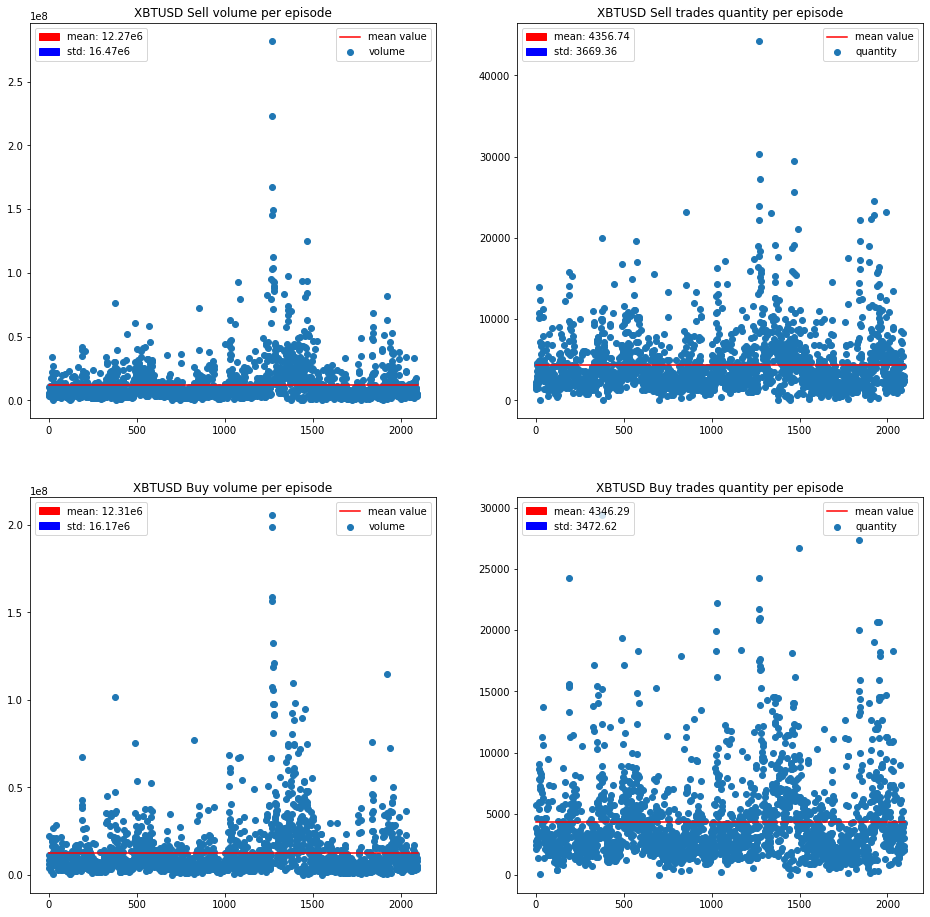

In [7]:
fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 2

labels = ['XBTUSD Sell volume per episode', 'XBTUSD Sell trades quantity per episode', 
          'XBTUSD Buy volume per episode', 'XBTUSD Buy trades quantity per episode']
for i, value, title in zip(range(1, columns*rows +1), [df.xss, df.xst, df.xbs, df.xbt], labels):
    
    mean, std = value.mean(), value.std()
    
    if i % 2 != 0:
        mean /= 1e6
        std  /= 1e6
        text  = 'e6'
        label = 'volume'
    else:
        text = ''
        label = 'quantity'
    
    patches = [
        mpatches.Patch(color='red', label=f'mean: {mean:.2f}{text}'),
        mpatches.Patch(color='blue', label=f'std: {std:.2f}{text}')
    ]
    fig.add_subplot(rows, columns, i)
    plt.scatter(range(0, len(value)), value, label=label)
    plt.plot([0, len(value)], [value.mean(), value.mean()], c='red', label='mean value')
    
    main_legend = plt.legend(loc=1)
    plt.legend(handles=patches, loc=2)
    plt.gca().add_artist(main_legend)
    plt.title(title)
    
plt.show()

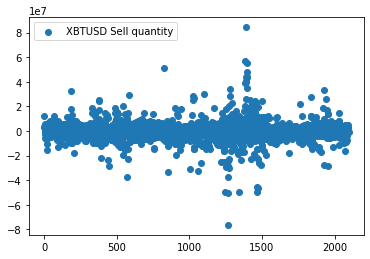

In [8]:
plt.scatter(range(0, len(storage)), df.xbs - df.xss, label='XBTUSD Sell quantity')
plt.legend()